# Evaluation of Token Classification with OpenAI GPT Models


## Import Python packages

In [1]:
from os import listdir
from os.path import isfile, join
import json

import pandas as pd
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

from datasets import load_dataset

## Import dataset

In this experiment, we use the GeoEDdA dataset which contains semantic annotations (at the token and span levels) for named entities (i.e., Spatial, Person, and Misc), nominal entities, spatial relations, and geographic coordinates. Nested named entities also present in this dataset were not considered in this experiment.

The dataset is available in the HuggingFace Hub: https://huggingface.co/datasets/GEODE/GeoEDdA

* Load the GeoEDdA dataset from the HuggingFace Hub:

In [2]:
dataset = load_dataset("GEODE/GeoEDdA")
test_set = pd.DataFrame(dataset['test'])
test_set.head()

,text,meta,tokens,spans
0,"COMPIEGNE, (Géog. mod.) ville de France, dans ...","{'volume': 3, 'head': 'COMPIEGNE', 'author': '...","[{'text': 'COMPIEGNE', 'start': 0, 'end': 9, '...","[{'text': 'COMPIEGNE', 'start': 0, 'end': 9, '..."
1,"HILPERHAUSEN, (Géog.) ville d'Allemagne en Fra...","{'volume': 8, 'head': 'HILPERHAUSEN', 'author'...","[{'text': 'HILPERHAUSEN', 'start': 0, 'end': 1...","[{'text': 'HILPERHAUSEN', 'start': 0, 'end': 1..."
2,"Patane ou Patany, (Géog. mod.) royaume des Ind...","{'volume': 12, 'head': 'Patane ou Patany', 'au...","[{'text': 'Patane', 'start': 0, 'end': 6, 'id'...","[{'text': 'Patane ou Patany', 'start': 0, 'end..."
3,"* ABYDE ou ABYDOS, sub. Ville maritime de Phry...","{'volume': 1, 'head': 'ABYDE ou ABYDOS', 'auth...","[{'text': '*', 'start': 0, 'end': 1, 'id': 0, ...","[{'text': 'ABYDE ou ABYDOS', 'start': 2, 'end'..."
4,"DUSSELDORP, (Géog. mod.) ville du cercle de We...","{'volume': 5, 'head': 'DUSSELDORP', 'author': ...","[{'text': 'DUSSELDORP', 'start': 0, 'end': 10,...","[{'text': 'DUSSELDORP', 'start': 0, 'end': 10,..."


In [3]:
tagset = ['Domain-mark','Head','NC-Person','NC-Spatial','NP-Misc','NP-Person','NP-Spatial','Relation','Latlong']

def filter_annotations(doc, tagset):
    result = ['O'] * len(doc['tokens'])
    for span in doc['spans']:
        if(span['label'] in tagset):
            for i in range(span['token_start'], span['token_end'] + 1):
                if(result[i] == 'O' or span['label'] == 'Latlong'):
                    result[i] = span['label']
                elif(result[i] == ['Latlong']):
                    break
    return result


* Add a new column with the list of tags (one tag per token):

In [4]:
test_set['tags'] = test_set.apply(lambda x: filter_annotations(x, tagset), axis=1)
test_set.head()

,text,meta,tokens,spans,tags
0,"COMPIEGNE, (Géog. mod.) ville de France, dans ...","{'volume': 3, 'head': 'COMPIEGNE', 'author': '...","[{'text': 'COMPIEGNE', 'start': 0, 'end': 9, '...","[{'text': 'COMPIEGNE', 'start': 0, 'end': 9, '...","[Head, O, O, Domain-mark, Domain-mark, Domain-..."
1,"HILPERHAUSEN, (Géog.) ville d'Allemagne en Fra...","{'volume': 8, 'head': 'HILPERHAUSEN', 'author'...","[{'text': 'HILPERHAUSEN', 'start': 0, 'end': 1...","[{'text': 'HILPERHAUSEN', 'start': 0, 'end': 1...","[Head, O, O, Domain-mark, Domain-mark, O, NC-S..."
2,"Patane ou Patany, (Géog. mod.) royaume des Ind...","{'volume': 12, 'head': 'Patane ou Patany', 'au...","[{'text': 'Patane', 'start': 0, 'end': 6, 'id'...","[{'text': 'Patane ou Patany', 'start': 0, 'end...","[Head, Head, Head, O, O, Domain-mark, Domain-m..."
3,"* ABYDE ou ABYDOS, sub. Ville maritime de Phry...","{'volume': 1, 'head': 'ABYDE ou ABYDOS', 'auth...","[{'text': '*', 'start': 0, 'end': 1, 'id': 0, ...","[{'text': 'ABYDE ou ABYDOS', 'start': 2, 'end'...","[O, Head, Head, Head, O, O, O, NC-Spatial, NC-..."
4,"DUSSELDORP, (Géog. mod.) ville du cercle de We...","{'volume': 5, 'head': 'DUSSELDORP', 'author': ...","[{'text': 'DUSSELDORP', 'start': 0, 'end': 10,...","[{'text': 'DUSSELDORP', 'start': 0, 'end': 10,...","[Head, O, O, Domain-mark, Domain-mark, Domain-..."


## Evaluation

Several iterations of the token classification task have been performed. The predictions from all the iterations can be loaded and evaluated.

In [5]:
def load_predictions(path):
    files = sorted([f for f in listdir(path) if isfile(join(path, f))])
    predictions = [] # contains the predictions of each iteration
    for file in files:
        with open(join(path, file), encoding='utf-8') as f:
            predictions.append(json.load(f))

    return predictions


def formatting_ner(pred_sentence, true_sentence):
    formatted_pred_sentence = []
    i = 0
    j = 0
    while(i < len(pred_sentence['entities']) and j < len(true_sentence['tokens'])):
        if('text' not in list(pred_sentence['entities'][i].keys())):
            formatted_pred_sentence.append('O')
            i += 1
            j += 1
        elif(pred_sentence['entities'][i]['text'] == true_sentence['tokens'][j]['text'] and 'label' in list(pred_sentence['entities'][i].keys())):
            formatted_pred_sentence.append(pred_sentence['entities'][i]['label'])
            i += 1
            j += 1
        else:
            j += 1
            formatted_pred_sentence.append('O')
    while(j < len(true_sentence['tokens'])):
        formatted_pred_sentence.append('O')
        j += 1
    return formatted_pred_sentence


def format_sentences(pred, true):
    formatted_pred_sentences = []
    for pred_sentence, true_sentence in zip(pred, true.iterrows()):
        formatted_pred_sentences.append(formatting_ner(pred_sentence,true_sentence[1]))
    return formatted_pred_sentences


def evaluate(predictions, test_set):
    classification_reports = []
    for iteration_predictions in predictions:
        formatted_sentences = format_sentences(iteration_predictions, test_set)
        pred_sentences_flat = [element for pred_sentences in formatted_sentences for element in pred_sentences]
        trues_flat = [element for true_sentence in list(test_set['tags']) for element in true_sentence]
        classification_reports.append(classification_report(trues_flat, pred_sentences_flat, output_dict=True, digits=3, labels=[tag for tag in tagset if tag != 'O']))
    return classification_reports


def get_avg_scores(classification_reports, score='f1-score'):
    avg_scores = {}
    for report in classification_reports:
        for tag in report.keys():
            if tag not in avg_scores:
                avg_scores[tag] = []
            avg_scores[tag].append(report[tag][score])

    avg_scores = {tag: sum(scores)/len(scores) for tag, scores in avg_scores.items()}
    return avg_scores


def bar_plot(scores, tagset, score='f1-score'):
    fig, ax = plt.subplots(figsize=(10, 5))
    barWidth = 0.2
    bars = [[data[tag] for tag in tagset if tag != 'O'] for data in scores.values()]
    r = [range(len(bars[0]))]
    for i in range(1, len(bars)):
        r.append([x + barWidth + 0.02 for x in r[i-1]])
    colors = ['#0072B2', '#D55E00', '#CC79A7', '#E69F00', '#56B4E9'] # Colorblind-friendly palette
    for i in range(len(bars)):
        ax.bar(r[i], bars[i], color=colors[i], width=barWidth, label=f'{list(scores.keys())[i]}')
    ax.set_xticks([r + barWidth for r in range(len(bars[0]))])
    ax.set_xticklabels(tagset, rotation=30)
    ax.tick_params(bottom=False, left=False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_color('#DDDDDD')
    ax.set_axisbelow(True)
    ax.yaxis.grid(True, color='#EEEEEE')
    ax.xaxis.grid(False)
    ax.set_xlabel('Token classes', labelpad=15, color='#333333')
    ax.set_ylabel(score, labelpad=15, color='#333333')
    plt.legend(loc=(1.04, 0.7))
    plt.show()

    return fig
    

In [6]:
models = ['gpt3.5', 'gpt4', 'gpt4o', 'o1-mini']
metrics = ['precision', 'recall', 'f1-score']

* Get classification report for GPT 3.5: 

In [7]:
path = join('predictions','token_classification_' + models[0])

predictions = load_predictions(path)
classification_reports = evaluate(predictions, test_set)

# display report of the first iteration
classification_reports[0]

{'Domain-mark': {'precision': 0.9740932642487047,
  'recall': 0.47959183673469385,
  'f1-score': 0.6427350427350428,
  'support': 392.0},
 'Head': {'precision': 0.8860759493670886,
  'recall': 0.2755905511811024,
  'f1-score': 0.42042042042042044,
  'support': 254.0},
 'NC-Person': {'precision': 0.6470588235294118,
  'recall': 0.0990990990990991,
  'f1-score': 0.171875,
  'support': 222.0},
 'NC-Spatial': {'precision': 0.8578431372549019,
  'recall': 0.2956081081081081,
  'f1-score': 0.4396984924623116,
  'support': 592.0},
 'NP-Misc': {'precision': 0.26666666666666666,
  'recall': 0.06857142857142857,
  'f1-score': 0.10909090909090909,
  'support': 175.0},
 'NP-Person': {'precision': 0.6120689655172413,
  'recall': 0.35858585858585856,
  'f1-score': 0.45222929936305734,
  'support': 198.0},
 'NP-Spatial': {'precision': 0.925,
  'recall': 0.41283124128312415,
  'f1-score': 0.570877531340405,
  'support': 717.0},
 'Relation': {'precision': 0.6102941176470589,
  'recall': 0.3672566371681

* Display average f1-scores for each tag:

In [8]:
get_avg_scores(classification_reports, score=metrics[2])

{'Domain-mark': 0.6449302059713803,
 'Head': 0.42670183111543497,
 'NC-Person': 0.15876207892359986,
 'NC-Spatial': 0.4420570246625014,
 'NP-Misc': 0.11298077508444071,
 'NP-Person': 0.4823060157966741,
 'NP-Spatial': 0.5802028827335182,
 'Relation': 0.4705836761028161,
 'Latlong': 0.5663276570224979,
 'micro avg': 0.4950721989001122,
 'macro avg': 0.43165023860142926,
 'weighted avg': 0.48772035944131265}

* Get micro average scores for each model:

In [9]:
for model in models:
    path = join('predictions','token_classification_' + model)
    predictions = load_predictions(path)
    classification_reports = evaluate(predictions, test_set)
    
    print(f'{model}', end=':\t')

    for metric in metrics:
        scores = get_avg_scores(classification_reports, metric)
        print(f'{metric}', end=': ')
        print(scores['micro avg'], end='\t')
        #print("{:.2f}".format(scores['micro avg']), end='\t')
    print()

gpt3.5:	precision: 0.8110235262638774	recall: 0.3563703508309153	f1-score: 0.4950721989001122	
gpt4:	precision: 0.7471964114066004	recall: 0.6151411237140596	f1-score: 0.6747685185185185	
gpt4o:	precision: 0.6826600017115714	recall: 0.7191374307570562	f1-score: 0.7003991389172175	


* Plot average scores for each GPT model:

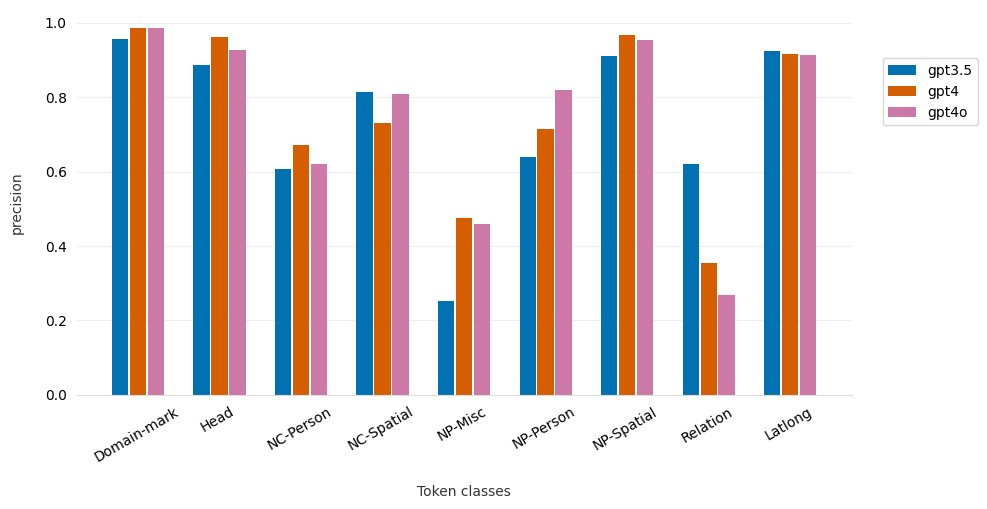

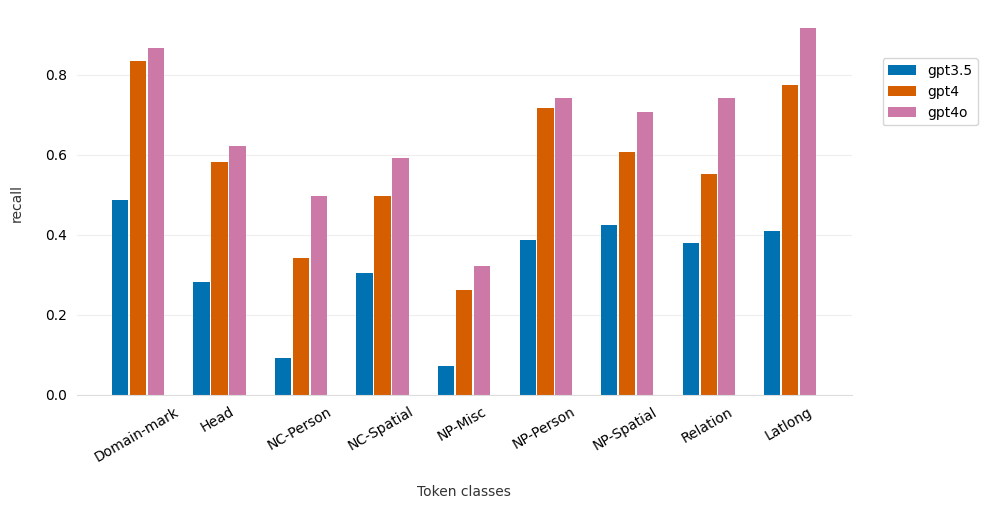

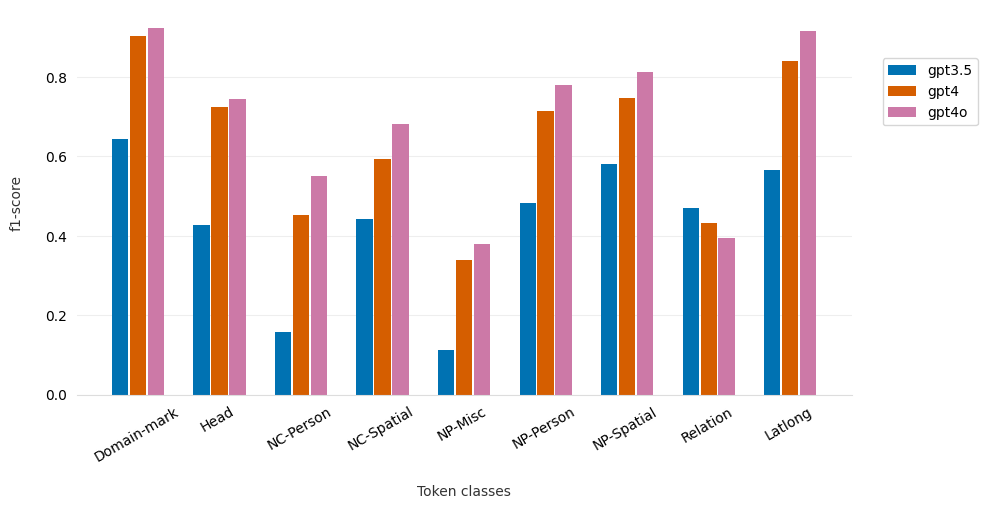

In [10]:
eval_scores = {}

for metric in metrics:
    for model in models:
        path = join('predictions','token_classification_' + model)
        predictions = load_predictions(path)
        classification_reports = evaluate(predictions, test_set)
        eval_scores[model] = get_avg_scores(classification_reports, metric)

    bar_plot(eval_scores, tagset, metric)


* Comparison with a [fine-tuned BERT](https://huggingface.co/GEODE/bert-base-french-cased-edda-ner) scores:

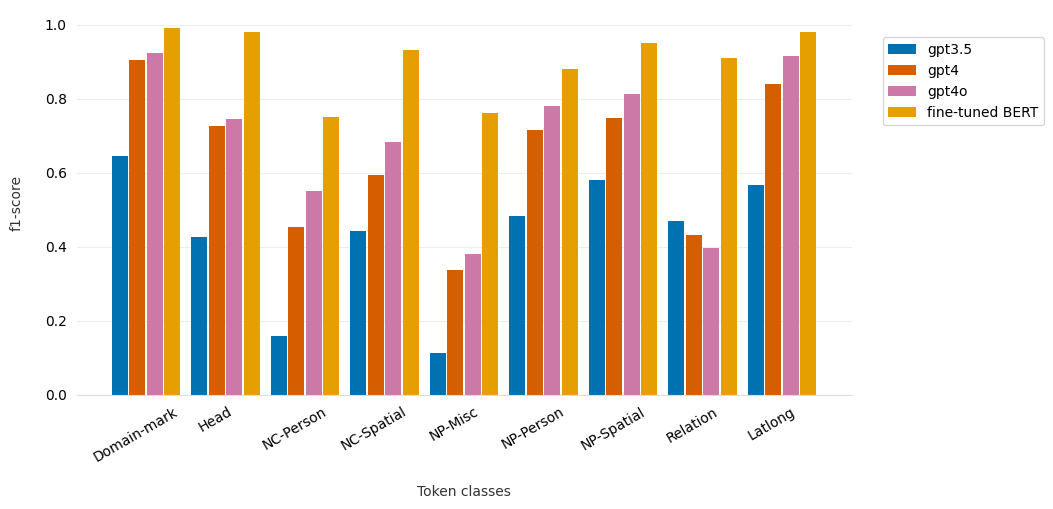

In [11]:
bert_f1scores =  {
    'Domain-mark': 0.99,
    'Head': 0.98,
    'NC-Person': 0.75,
    'NC-Spatial': 0.93,
    'NP-Misc': 0.76,
    'NP-Person': 0.88,
    'NP-Spatial': 0.95,
    'Relation': 0.91,
    'Latlong': 0.98
}

eval_scores = {}

for model in models:
    path = join('predictions','token_classification_' + model)
    predictions = load_predictions(path)
    classification_reports = evaluate(predictions, test_set)
    eval_scores[model] = get_avg_scores(classification_reports, metric)

eval_scores['fine-tuned BERT'] = bert_f1scores

fig = bar_plot(eval_scores, tagset, metric)

In [12]:
# save the plot
fig.savefig(join('evaluations','token_classification_gpt_vs_bert_f1scores.png'), bbox_inches='tight')